In [ ]:
#default_exp core

# Core XLA extensions

In [ ]:
#hide
#colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
#hide
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash 

## Install fastai

_Freezing fastcore and fastai versions to 1.0.0 and 2.0.0 respectively for reproducibility_

In [ ]:
#hide_output
#colab
!pip install -Uqq fastcore==1.0.0
!pip install -Uqq fastai==2.0.0

## Setup torch XLA


This is the official way to install Pytorch-XLA 1.6 as per [instructions here](https://github.com/pytorch/xla/releases/tag/v1.6.0)

In [ ]:
#hide_output
#colab
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 131.2MB 74kB/s 
     |████████████████████████████████| 61kB 2.1MB/s 
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [ ]:
#hide
#colab
# use this for getting pytorch XLA nightly version
# VERSION = "20200707"  #@param ["1.5" , "20200325","20200707", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [ ]:
#hide
!pip freeze | grep torch
!pip freeze | grep fastai
!pip freeze | grep fastcore

torch==1.6.0+cu101
torch-xla==1.6
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.7.0+cu101
fastai==2.0.0
fastcore==1.0.0


In [ ]:
#hide
#colab
%cd /content/drive/My\ Drive/fastai_xla_extensions

/content/drive/My Drive/fastai_xla_extensions


## Check if XLA is available

In [ ]:
#export
#colab
#hide_output
XLA_AVAILABLE = True
try:
    import torch_xla.core.xla_model as xm
except ImportError as e:
    XLA_AVAILABLE = False

This next code routine handles the possibility of running the package when the environment does not provide a TPU (e.g. CI env, local, etc) by providing mock implementations 

In [ ]:
#exporti
if not globals().get('XLA_AVAILABLE'):
    from types import SimpleNamespace
    import torch.cuda
    def fake_opt_step(opt,barrier=False):
        opt.step()
    def fake_device(n=None, devkind=None):
        gpu_available = torch.cuda.is_available()
        return torch.device(torch.cuda.current_device()) if gpu_available else torch.device('cpu')
    xm = SimpleNamespace(
        optimizer_step = fake_opt_step,
        xla_device = fake_device
    )


## XLA Optim Proxy
`XLAOptimProxy` is a class which has overridden the `step` method to call the Pytorch-XLA function `xm.optimizer_step` which synchronizes the XLA graph. All other calls to `XLAOptimProxy` just forward it to the internal `self.opt` instance.

In [ ]:
#export
class XLAOptimProxy:
    "Proxy optimizer to override `opt.step` with Pytorch XLA sync method `xm.optimizer_step` "  
    def __init__(self,opt, barrier=True):
        self.opt = opt
        self._barrier = barrier
        
    def xla_step(self):
        xm.optimizer_step(self.opt,barrier=self._barrier) # sync on gradient update
        
    def __getattr__(self,name):
        if name == 'step': # override proxying for step
            return getattr(self,'xla_step')
        if name in ('barrier','_barrier'):
            return getattr(self,name)
      
        # proxy everything else
        return getattr(self.opt,name)
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v 

## XLA Opt Callback
This callback replaces the learner's `opt` with an instance of `XLAOptimProxy` that proxies the original `opt` during the beginning of the `fit` method and restores the original `opt` after the `fit`.

It also sets the `dataloaders.device` and the `learn.model` to use a TPU core using the device returned by the `xm.xla_device()` method.

In [ ]:
#export
from fastai.callback.core import Callback
from fastai.data.core import DataLoaders

def set2xla_device(dls:DataLoaders):
    'set dataloaders (including loaders inside) to xla_device'
    dls.device = xm.xla_device()
    for loader in dls.loaders:
        loader.device = dls.device

class XLAOptCallback(Callback):
    'Callback to replace `opt.step` with `xm.optimizer_step(opt)` as required to run on TPU'
    def __init__(self, barrier=True):
        self._barrier = barrier

    def before_fit(self):
        'replace opt with proxy which calls `xm.optimizer_step` instead of `opt.step` and set `dls.device` and model to `xla_device`'
        set2xla_device(self.dls)
        self.model.to(self.dls.device)
        if self.learn.opt is not None:
            if not isinstance(self.learn.opt,XLAOptimProxy):
                opt = self.learn.opt
                self.learn.opt = XLAOptimProxy(opt, barrier=self._barrier)
                
    def after_fit(self):
        'restore original opt '
        if isinstance(self.learn.opt, XLAOptimProxy):
            opt = self.learn.opt.opt
            self.learn.opt = opt
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v

If XLA is available, then it is assumed that XLA is intended 
to be used -- this requires the following:



* The `XLAOptCallback` (which enables the `Learner` to call `xm.optimizer_step` via the `XLAOptimProxy`) is automatically added as a default callback. 

In [ ]:
#export
if globals().get('XLA_AVAILABLE'):
    from fastcore.foundation import defaults
    if hasattr(defaults,'callbacks'):
        if XLAOptCallback not in defaults.callbacks: 
            defaults.callbacks.append(XLAOptCallback)
    else:
        defaults.callbacks = [XLAOptCallback]

* Override the `Learner.summary` method to set the `learner.dls` to use an `xla_device`

In [ ]:
#export
if globals().get('XLA_AVAILABLE'):
    from fastcore.foundation import patch
    from fastai.learner import Learner
    from fastai.callback.hook import summary as orig_summary
    @patch
    def summary(self:Learner):
        set2xla_device(self.dls)
        return orig_summary(self)
   

## Example: Create an MNIST classifier
This is an example of the fastai_xla_extensions library
in action.

First, we import fastai libraries. 

In [ ]:
#hide
#colab
%cd /content

In [ ]:
from fastai.vision.all import *
from fastai.callback.training import GradientAccumulation

Load data

In [ ]:
path = untar_data(URLs.MNIST_TINY)
Path.BASE_PATH = path

Create datablock

_(note: `batch_tfms` is empty -- this is still being debugged for slow performance)_

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)

Set dataloader to load the batches to the tpu

In [ ]:
dls = datablock.dataloaders(path)

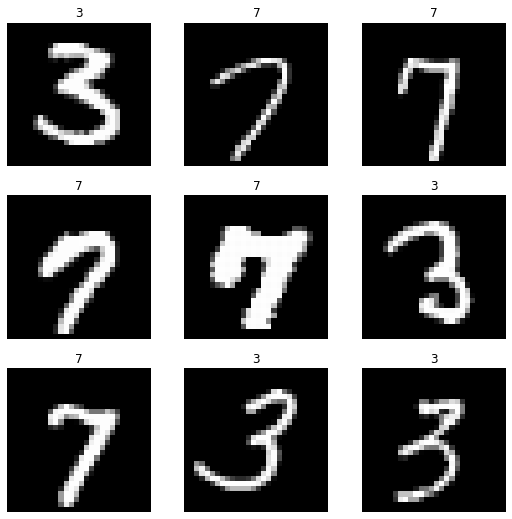

In [ ]:
dls.show_batch()

Create the Learner

(note use of `pretrained = False` due to [current bug re pretrained flag](https://github.com/butchland/fastai_xla_extensions/issues/14))  

In [ ]:
# learner = cnn_learner(dls, resnet18, metrics=accuracy)
learner = cnn_learner(dls, resnet18, pretrained=False, metrics=accuracy) # see current bug re pretrained https://github.com/butchland/fastai_xla_extensions/issues/14 

The `learner` object should have an `xla_opt` attribute which confirms that `XLAOptCallback` has been added to the list of callbacks for this learner.

In [ ]:
#colab
learner.xla_opt

XLAOptCallback

In [ ]:
#colab
learner.xla_opt.barrier

True

In [ ]:
#colab
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

In [ ]:
#colab
learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, XLAOptCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch 

This is just a simple callback to check that the `learner.model` and the `learner.dls` are both using the `xla_device`

In [ ]:
#colab
class CheckXLADeviceCallback(Callback):
    def before_epoch(self):
        print(f'dls device: {self.dls.device} model device: {one_param(self.learn.model).device}')

Run `fit` to train the model.

In [ ]:
#colab
learner.fit(1, cbs=[CheckXLADeviceCallback()])

epoch,train_loss,valid_loss,accuracy,time
0,0.402065,1.592010,0.505007,00:17


dls device: xla:1 model device: xla:1


In [ ]:
#colab
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.105769,2.880296,0.505007,00:02
1,0.103337,2.262531,0.573677,00:02
2,0.125320,0.227011,0.931330,00:02
3,0.093192,0.056601,0.985694,00:02
4,0.074982,0.022689,0.992847,00:02


In [ ]:
#colab
learner.fit_one_cycle(4, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.021371,0.013632,0.995708,00:09
1,0.018927,0.008917,0.995708,00:02
2,0.013505,0.007390,0.995708,00:02
3,0.010866,0.007171,0.995708,00:02


Gradient Accum callback (which calls CancelBatchException) should still work.

An alternative design for the XLA Opt Callback which raises the CancelBatchException in the `after_backward` method (after executing `xm.optimizer_step` and `opt.zero_grad`) would interfere with the Gradient Accum callback (which raises `CancelBatchException` in the `after_backward` method to [skip the gradient updates](https://github.com/fastai/fastai/blob/master/fastai/callback/training.py#L22) in order to accumulate the gradients).

The current design (add/remove `XLAOptimProxy` during `before_fit` and `after_fit` callback lifecycle methods) is less disruptive and more compatible with other callbacks.

In [ ]:
#colab
learner.fit_one_cycle(4,cbs=[GradientAccumulation(n_acc=2),])

epoch,train_loss,valid_loss,accuracy,time
0,0.017050,0.339187,0.911302,00:02
1,0.078925,0.280144,0.978541,00:02
2,0.093771,0.013446,0.992847,00:02
3,0.069861,0.010571,0.997139,00:02


Valid loss has kind of plateaued so this look ok.  

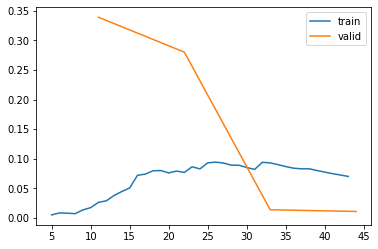

In [ ]:
#colab
learner.recorder.plot_loss()

Plot moms and lr across batches/epochs

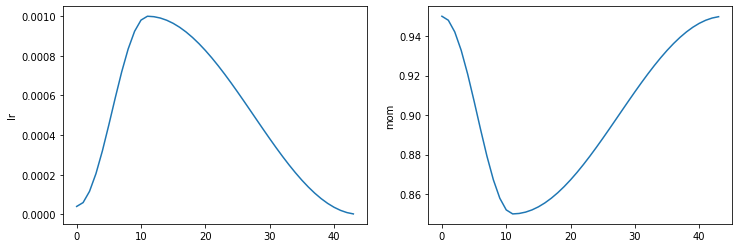

In [ ]:
#colab
learner.recorder.plot_sched()

Get Classification Interpretation for more details on model performance

In [ ]:
#colab
interp = ClassificationInterpretation.from_learner(learner)

Plot confusion matrix

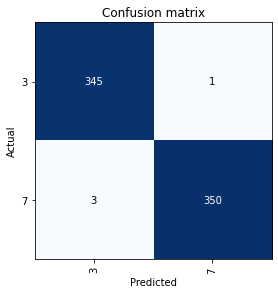

In [ ]:
#colab
interp.plot_confusion_matrix()

Samples where model was most confused

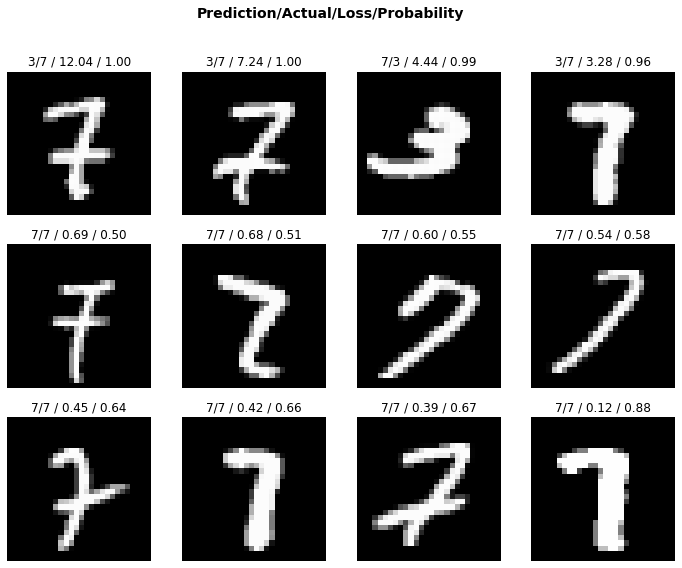

In [ ]:
#colab
interp.plot_top_losses(12)

**End of Notebook**